In [64]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from datetime import datetime as dt

In [84]:
years = [i.name for i in os.scandir(f"inmet-data") if i.is_dir()]
location = "A801"

filenames = []
for year in years[1:]:
    filenames.extend(
        [
            f"{year}/{file.name}"
            for file in os.scandir(f"inmet-data/{year}")
            if location in file.name
        ]
    )
dfs = []
for f in filenames:
    df = pd.read_csv(f"inmet-data/{f}", delimiter=";", header=8, encoding="iso-8859-1")
    dfs.append(
        df.rename(
            columns={
                "HORA (UTC)": "Hora UTC",
                "DATA (YYYY-MM-DD)": "Data",
                "RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)",
            }
        )
    )

raw_data = pd.concat(dfs).reset_index()
raw_data

,index,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,0,2001-01-01,00:00,0,1009,1009,"1008,5",-9999,21,"15,8",...,"20,9","16,1","15,6",72.0,69.0,72.0,90.0,"5,8","2,1",NaN
1,1,2001-01-01,01:00,0,"1009,4","1009,4",1009,-9999,"20,5","15,6",...,"20,5","15,8","15,5",73.0,71.0,73.0,109.0,"5,3","2,7",NaN
2,2,2001-01-01,02:00,0,"1009,1","1009,3","1009,1",-9999,20,"15,5",...,20,"15,6","15,5",75.0,73.0,75.0,96.0,"4,2","1,8",NaN
3,3,2001-01-01,03:00,0,"1008,8","1009,1","1008,8",-9999,"19,9","15,5",...,"19,8","15,6","15,5",76.0,75.0,76.0,110.0,"4,3","1,6",NaN
4,4,2001-01-01,04:00,0,"1008,7","1008,9","1008,7",-9999,"19,4","15,6",...,"19,4","15,6","15,5",78.0,76.0,78.0,136.0,"4,2","2,2",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200371,8779,2004-12-31,19:00,0,"1009,4","1009,7","1009,4",2788,"29,7","17,7",...,"29,2","18,3","16,7",51.0,45.0,49.0,146.0,"7,4","2,4",NaN
200372,8780,2004-12-31,20:00,0,"1009,2","1009,4","1009,2",2089,"28,2","18,6",...,"28,1","18,9","17,7",56.0,49.0,56.0,140.0,"8,5","3,4",NaN
200373,8781,2004-12-31,21:00,0,"1009,3","1009,3","1009,1",1293,"27,1","17,4",...,"27,1","18,8","17,4",58.0,55.0,55.0,131.0,"8,7","3,7",NaN
200374,8782,2004-12-31,22:00,0,"1009,7","1009,7","1009,3",415,"25,4","18,2",...,"25,4","18,4","17,1",64.0,55.0,64.0,133.0,"7,6","3,3",NaN


In [93]:
cols = raw_data.columns

# treating hour data bc it's not super consistent
raw_data[cols[2]] = raw_data[cols[2]].apply(
    lambda s: ":".join([s[:2], s[2:4]]) if isinstance(s, str) and "UTC" in s else s
)
# same for dates
raw_data[cols[1]] = raw_data[cols[1]].apply(
    lambda s: s.replace("/", "-") if isinstance(s, str) else s
)


raw_data["datetime"] = pd.to_datetime(
    raw_data[cols[1]] + " " + raw_data[cols[2]], format="%Y-%m-%d %H:%M"
)


def parseToFloat(col):
    return (
        raw_data[col]
        .apply(lambda x: float(x.replace(",", ".")) if (isinstance(x, str)) else x)
        .apply(lambda x: np.nan if x == -9999.0 else x)
    )


# global-radiation
raw_data["global-radiation"] = parseToFloat(cols[7])

# precipitation
raw_data["total-precipitation"] = parseToFloat(cols[3])

raw_data["relative-humidity"] = parseToFloat("UMIDADE RELATIVA DO AR, HORARIA (%)")

# temperature
raw_data["temperature-last-hour-max"] = parseToFloat(
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"
)
raw_data["temperature-last-hour-min"] = parseToFloat(
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"
)

# wind
raw_data["wind-speed"] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")
raw_data["wind-speed-max-gust"] = parseToFloat("VENTO, RAJADA MAXIMA (m/s)")

raw_data
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.drop(columns=cols[:21])
renamed_data

,datetime,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
0,2001-01-01 00:00:00,NaN,0.0,72.0,21.9,20.9,2.1,5.8
1,2001-01-01 01:00:00,NaN,0.0,73.0,20.9,20.5,2.7,5.3
2,2001-01-01 02:00:00,NaN,0.0,75.0,20.5,20.0,1.8,4.2
3,2001-01-01 03:00:00,NaN,0.0,76.0,20.0,19.8,1.6,4.3
4,2001-01-01 04:00:00,NaN,0.0,78.0,19.8,19.4,2.2,4.2
...,...,...,...,...,...,...,...,...
200371,2004-12-31 19:00:00,2788.0,0.0,49.0,29.8,29.2,2.4,7.4
200372,2004-12-31 20:00:00,2089.0,0.0,56.0,29.7,28.1,3.4,8.5
200373,2004-12-31 21:00:00,1293.0,0.0,55.0,28.4,27.1,3.7,8.7
200374,2004-12-31 22:00:00,415.0,0.0,64.0,27.0,25.4,3.3,7.6


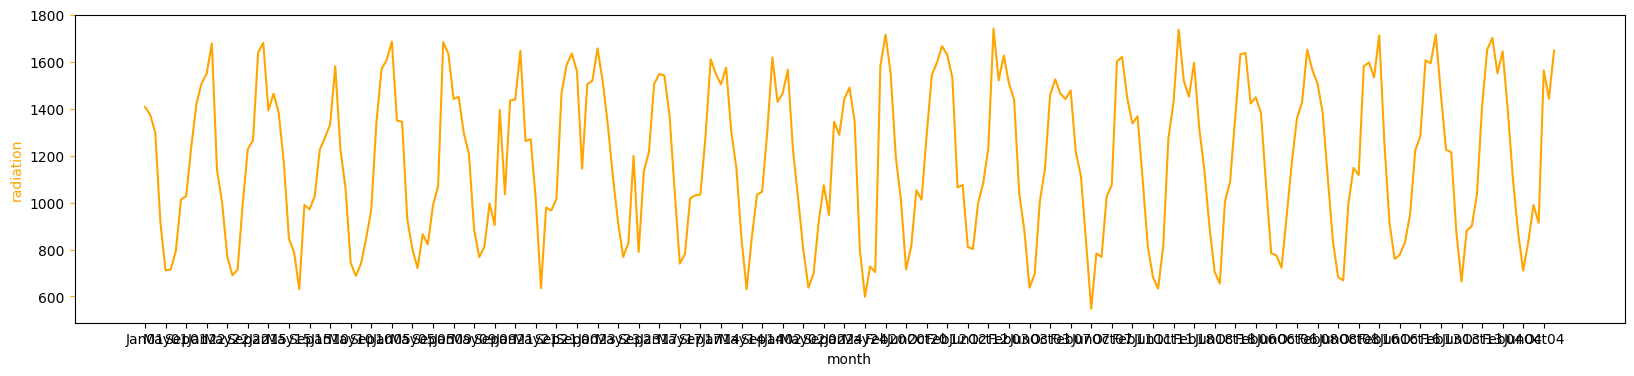

In [105]:
by_month = renamed_data
by_month["month"] = by_month["datetime"].apply(
    lambda d: pd.Timestamp.strftime(d, "%b%y")
)
monthly_radiation = by_month.groupby("month")["global-radiation"].transform("mean")
monthly_precipitation = by_month.groupby("month")["total-precipitation"].transform(
    "mean"
)
monthly_wind = by_month.groupby("month")["relative-humidity"].transform("mean")
months = by_month["month"]

fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot()


ax1.set_xlabel("month")

ax1.set_ylabel("radiation", color="orange")
ax1.plot(months, monthly_radiation, color="orange")
ax1.tick_params(axis="y", color="orange")

ticks, labels = ax1.get_xticks(), ax1.get_xticklabels()
ticks = [t for i, t in enumerate(ticks) if i % 4 == 0]
labels = [t for i, t in enumerate(labels) if i % 4 == 0]
plt.xticks(ticks=ticks, labels=labels)

# ax2= ax1.twinx()
# ax2.set_ylabel('precipitation')
# ax2.plot(months, monthly_precipitation)
# ax2.tick_params(axis='y')

# ax3 = ax1.twinx()
# ax3.set_ylabel("wind", color="green")
# ax3.plot(months, monthly_wind, color="green")
# ax3.tick_params(axis="y", color="green")

plt.show()